# Phylogenetic generalised regression and Phylogenetic ANCOVA

## Cleaning and loading data

### Loading packages

In [1]:
library("phytools")
library("nlme")
library("multcomp")
library("evomap")
library("geiger")
library("phylolm")
library("dplyr")

Le chargement a nécessité le package : ape

Le chargement a nécessité le package : maps

Le chargement a nécessité le package : mvtnorm

Le chargement a nécessité le package : survival

Le chargement a nécessité le package : TH.data

Le chargement a nécessité le package : MASS


Attachement du package : ‘TH.data’


L'objet suivant est masqué depuis ‘package:MASS’:

    geyser



Attachement du package : ‘dplyr’


L'objet suivant est masqué depuis ‘package:MASS’:

    select


L'objet suivant est masqué depuis ‘package:nlme’:

    collapse


L'objet suivant est masqué depuis ‘package:ape’:

    where


Les objets suivants sont masqués depuis ‘package:stats’:

    filter, lag


Les objets suivants sont masqués depuis ‘package:base’:

    intersect, setdiff, setequal, union




### Loading data

In [2]:
table<-read.table("data/table_complete_LDA.tsv", header = TRUE)
phy<-read.tree(file = "data/Tree_65_sp_murids.tree")

In [3]:
tablePANCOVA <- na.omit(table)

In [4]:
phy_omit <- drop.tip(phy,c("Uromys_imperator","Hyomys_goliath_2"))

### Creating useful functions

#### Plotting grade regression (after Smaers' evomap package)

In [5]:
pGLS.plotGrade<-function (Yvar, Xvar, data, tree, model, group, ...) 
{
    dataTemp <- pruneSample(na.omit(data), tree, group)$data
    treeTemp <- pruneSample(dataTemp, tree, group)$tree
    Y <- dataTemp[, which(colnames(dataTemp) == paste(Yvar))]
    X <- dataTemp[, which(colnames(dataTemp) == paste(Xvar))]
    dataGLS <- as.data.frame(cbind(Y, X))
    rownames(dataGLS) <- rownames(dataTemp)
     switch(model, BM = {
        pGLSTemp <- phylolm(Y ~ X, data=dataGLS, phy=treeTemp,model = "BM")
        }, lambda = {
        pGLSTemp <- phylolm(Y ~ X, data=dataGLS, phy=treeTemp,model = "lambda")
        })
    a <- summary(pGLSTemp)$coefficients[1, 1]
    b <- summary(pGLSTemp)$coefficients[2, 1]
    lines(c(min(X), max(X)), c((a + b * min(X)), (a + b * max(X))), 
        ...)
    points(X, Y, ...)
}

#### Extracting taxa name following their ecological group

In [6]:
extract.group<-function(tree, data_frame, group1){
  vec_gr1<-c()
  vec_gr2<-c()
  for (i in 1:nrow(data_frame)){
    if(data_frame[i,20]==group1){
      vec_gr1<-c(vec_gr1, which(tree$tip.label==data_frame[i,2]))
    }
    else{
      vec_gr2<-c(vec_gr2, which(tree$tip.label==data_frame[i,2]))
    }
  }
  return(list(vec_gr1, vec_gr2))
}

#### Automatised function performing phylogenetic GLS & ANCOVA

In [11]:
pancova<-function(temp_data, phy, df, iterator, spp, df_temp){
  
  temp_data[,1]<-log(temp_data[,1])
  
  rownames(temp_data)<-df[,2]
  
  colnames(temp_data)<-c("Dependent","Independent")

  Non_p<-unlist(extract.group(phy, df, "N")[1])
  P<-unlist(extract.group(phy, df, "N")[2])
  Non_p<-unlist(extract.group(phy, df, "N")[1])
  P<-unlist(extract.group(phy, df, "N")[2])

  plot(temp_data$Dependent~temp_data$Independent,col="white",pch=19,xlab="", ylab="",asp=1,cex.lab=2)
  pGLS.plotGrade("Dependent","Independent",temp_data,phy,model="BM",group=Non_p,col="#D2B48C",lwd=5,cex=1,pch=19)
  pGLS.plotGrade("Dependent","Independent",temp_data,phy,model="BM",group=P,col="#40826D",lwd=5,cex=1,pch=19)
  tipCol<-rep("#40826D",length(phy$tip.label))
  tipCol[Non_p]<-"#D2B48C"
  plot(phy,tip.col=tipCol,cex=0.6)
  df$Prehensility_LDA<-as.factor(df$Prehensility_LDA)
  corBM<-corBrownian(phy=phy,form=~spp)
    

    prehensility.ancova<-gls(log(Y)~log(X)*Group -1, correlation=corBM, data = df_temp)
    post.hoc<-glht(prehensility.ancova,linfct=mcp(Group="Tukey"))
    print(summary(post.hoc))
    df<-prehensility.ancova$dims$N-prehensility.ancova$dims$p
    alpha<-0.05
    ciBeta_Non_prehensile<-coef(prehensility.ancova)["log(X)"]+
    qt(c(alpha/2,1-alpha/2),df)*
    sqrt(prehensility.ancova$varBeta["log(X)","log(X)"])
    print(ciBeta_Non_prehensile)
    ciBeta_Prehensile<-coef(prehensility.ancova)["log(X)"]+
    coef(prehensility.ancova)["log(X):GroupP"]+
    qt(c(alpha/2,1-alpha/2),df)*
    sqrt(prehensility.ancova$varBeta[ "log(X)","log(X)"]+
    prehensility.ancova$varBeta["log(X):GroupP","log(X):GroupP"]+2*prehensility.ancova$varBeta["log(X)","log(X):GroupP"])
    CIs<-data.frame(parameter= paste("beta(",levels(table$Prehensility),")",sep=""),lower=c(ciBeta_Non_prehensile[1],ciBeta_Prehensile[1]), estimate=coef(prehensility.ancova)["log(X)"]+c(0, coef(prehensility.ancova)[c("log(X):GroupP")]), upper=c(ciBeta_Non_prehensile[2],ciBeta_Prehensile[2]))
    rownames(CIs)<-NULL
    print(intervals(prehensility.ancova))
    print(CIs)
}

## Performing the Phylogenetic linear regression and Covariance analyses

Warning message in mcp2matrix(model, linfct = linfct):
“covariate interactions found -- default contrast might be inappropriate”


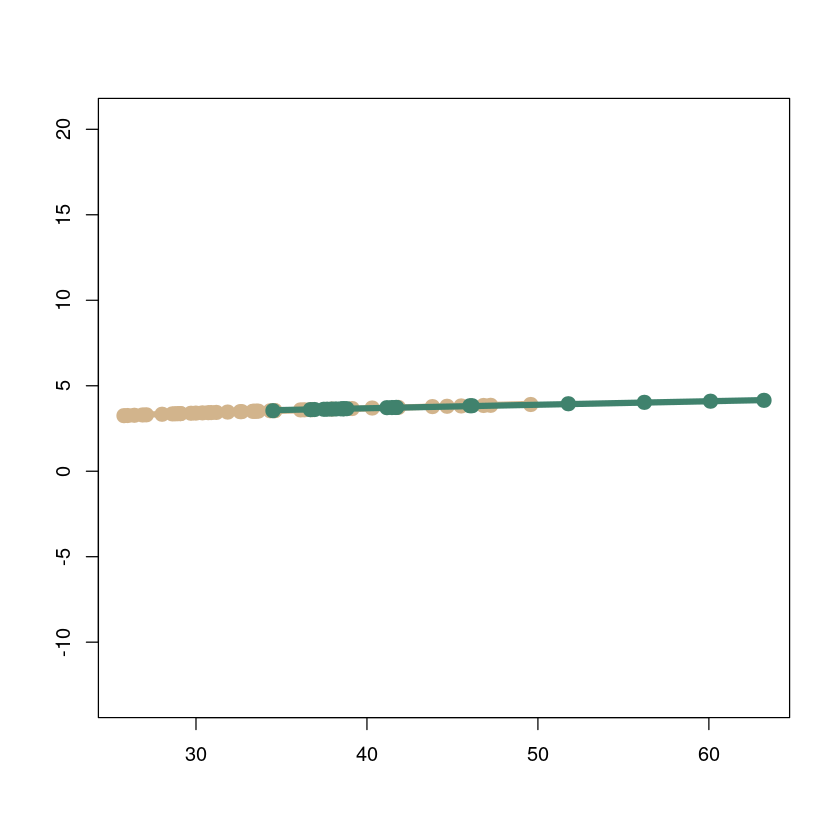


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: gls(model = log(Y) ~ log(X) * Group - 1, data = df_temp, correlation = corBM)

Linear Hypotheses:
           Estimate Std. Error z value Pr(>|z|)    
P - N == 0   6.9024     0.1753   39.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)

[1] 0.1368490 0.3033225
Approximate 95% confidence intervals

 Coefficients:
                   lower        est.     upper
log(X)         0.1368490 0.220085751 0.3033225
GroupN         3.1761050 3.352325669 3.5285464
GroupP         3.3523173 3.550025314 3.7477333
log(X):GroupP -0.1310686 0.006918524 0.1449057

 Residual standard error:
    lower      est.     upper 
0.1531660 0.1806982 0.2203907 
  parameter    lower  estimate     upper
1    beta() 0.136849 0.2200858 0.3033225
2    beta() 0.115348 0.2270043 0.3386605


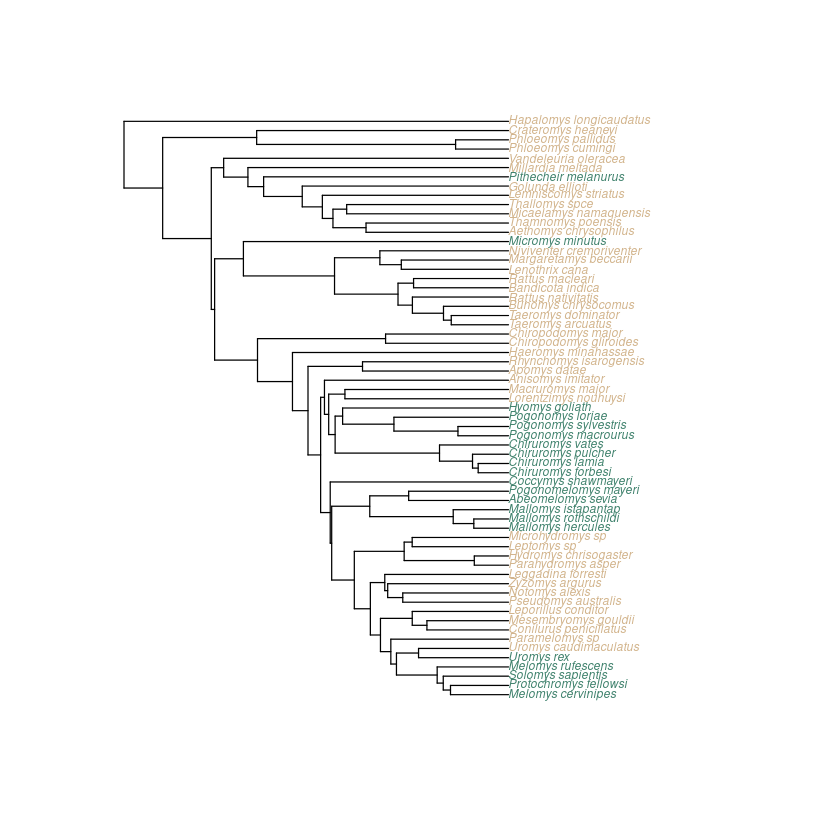

Warning message in mcp2matrix(model, linfct = linfct):
“covariate interactions found -- default contrast might be inappropriate”


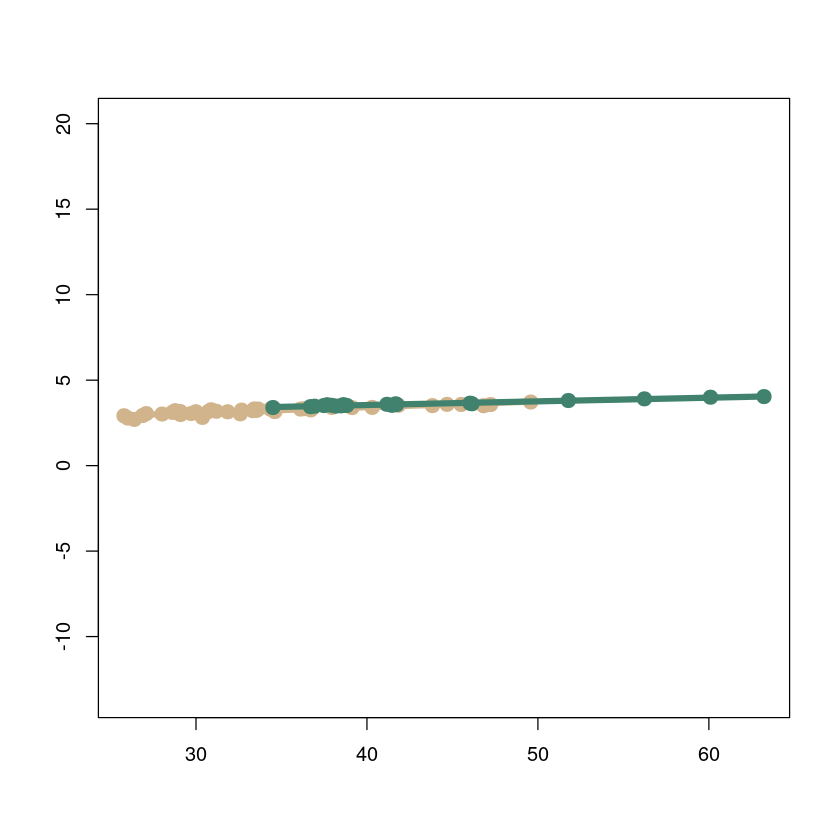


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: gls(model = log(Y) ~ log(X) * Group - 1, data = df_temp, correlation = corBM)

Linear Hypotheses:
           Estimate Std. Error z value Pr(>|z|)    
P - N == 0   6.4927     0.2559   25.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)

[1] 0.09906981 0.34206956
Approximate 95% confidence intervals

 Coefficients:
                    lower        est.     upper
log(X)         0.09906981  0.22056968 0.3420696
GroupN         2.80537854  3.06260633 3.3198341
GroupP         3.14153140  3.43012404 3.7187167
log(X):GroupP -0.21872991 -0.01731126 0.1841074

 Residual standard error:
    lower      est.     upper 
0.2235750 0.2637636 0.3217024 
  parameter      lower  estimate     upper
1    beta() 0.09906981 0.2205697 0.3420696
2    beta() 0.04027477 0.2032584 0.3662421


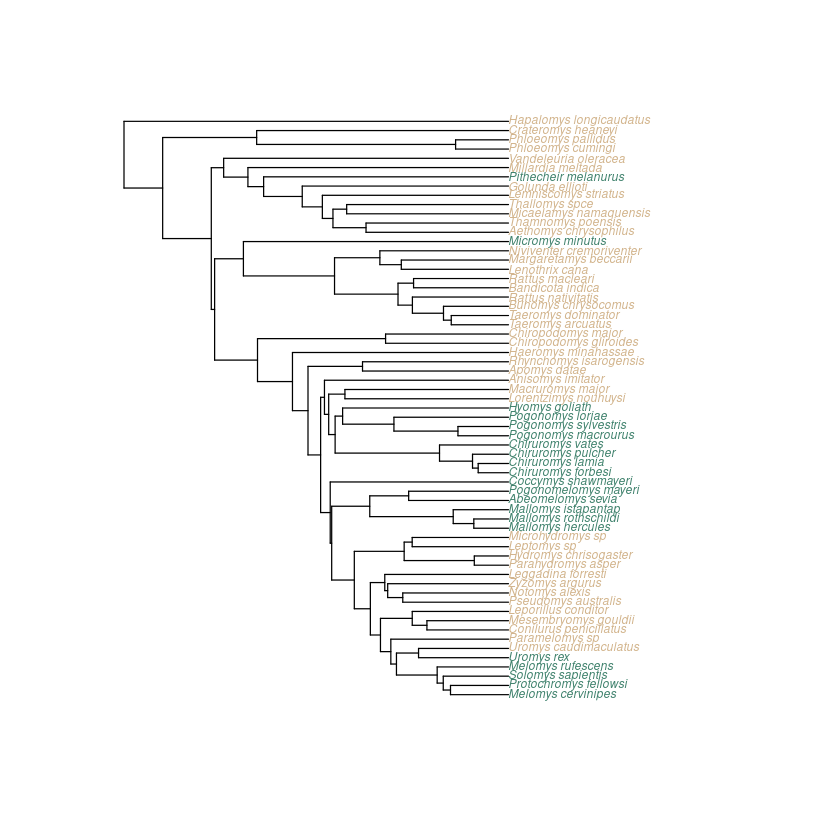

Warning message in mcp2matrix(model, linfct = linfct):
“covariate interactions found -- default contrast might be inappropriate”


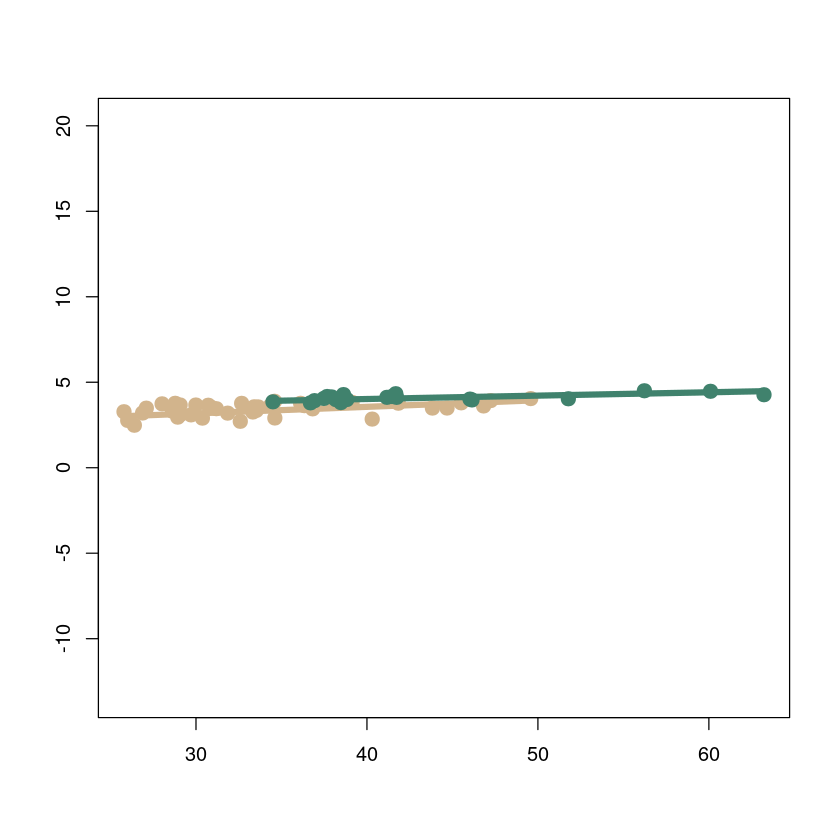


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: gls(model = log(Y) ~ log(X) * Group - 1, data = df_temp, correlation = corBM)

Linear Hypotheses:
           Estimate Std. Error z value Pr(>|z|)    
P - N == 0   7.3446     0.5352   13.72   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)

[1] -0.2780037  0.2301648
Approximate 95% confidence intervals

 Coefficients:
                   lower        est.     upper
log(X)        -0.2780037 -0.02391945 0.2301648
GroupN         2.8277645  3.36568702 3.9036096
GroupP         3.3754315  3.97894517 4.5824588
log(X):GroupP -0.3785312  0.04268155 0.4638943

 Residual standard error:
    lower      est.     upper 
0.4675468 0.5515904 0.6727538 
  parameter      lower    estimate     upper
1    beta() -0.2780037 -0.02391945 0.2301648
2    beta() -0.3220742  0.01876209 0.3595984


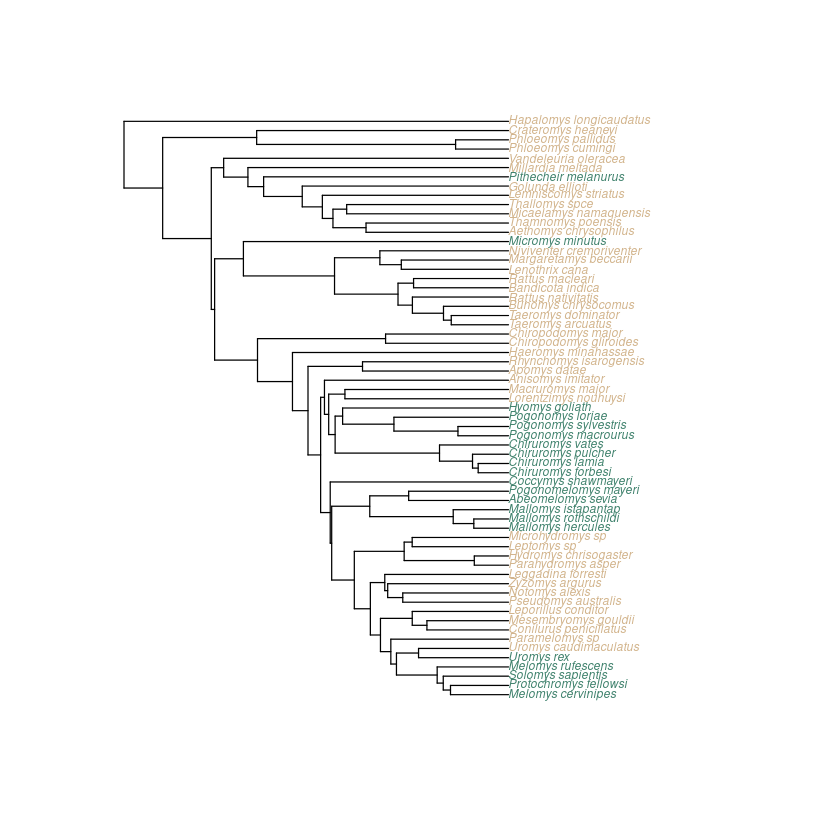

Warning message in mcp2matrix(model, linfct = linfct):
“covariate interactions found -- default contrast might be inappropriate”


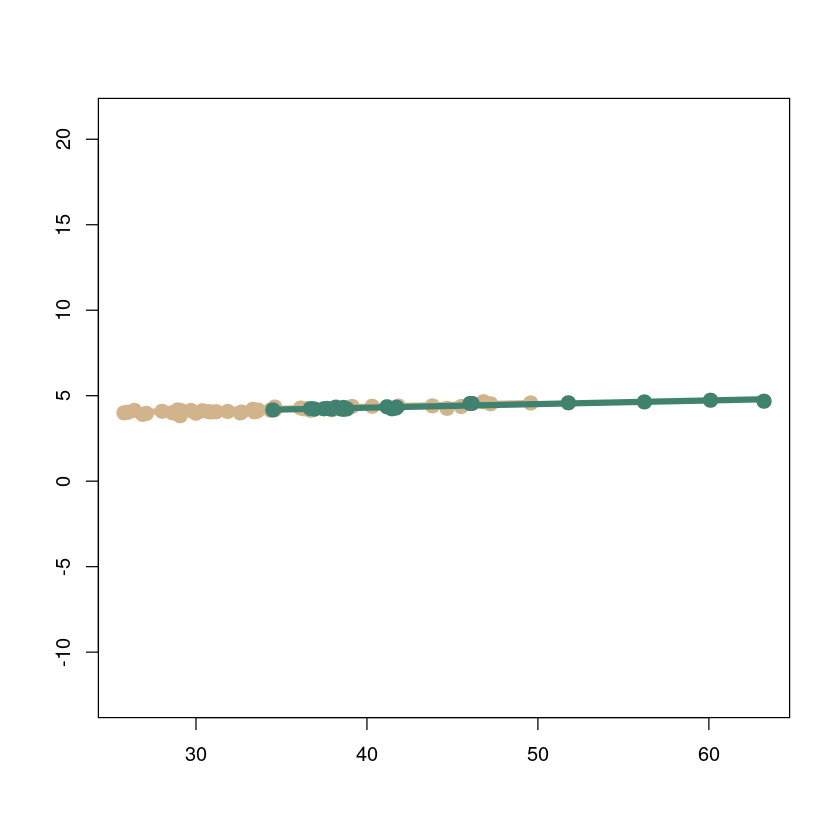


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: gls(model = log(Y) ~ log(X) * Group - 1, data = df_temp, correlation = corBM)

Linear Hypotheses:
           Estimate Std. Error z value Pr(>|z|)    
P - N == 0   8.2446     0.1722   47.87   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)

[1] 0.1216929 0.2852237
Approximate 95% confidence intervals

 Coefficients:
                    lower      est.     upper
log(X)         0.12169294 0.2034583 0.2852237
GroupN         3.89788635 4.0709921 4.2440978
GroupP         3.97944055 4.1736538 4.3678670
log(X):GroupP -0.01485967 0.1206884 0.2562364

 Residual standard error:
    lower      est.     upper 
0.1504585 0.1775041 0.2164950 
  parameter     lower  estimate     upper
1    beta() 0.1216929 0.2034583 0.2852237
2    beta() 0.2144641 0.3241467 0.4338293


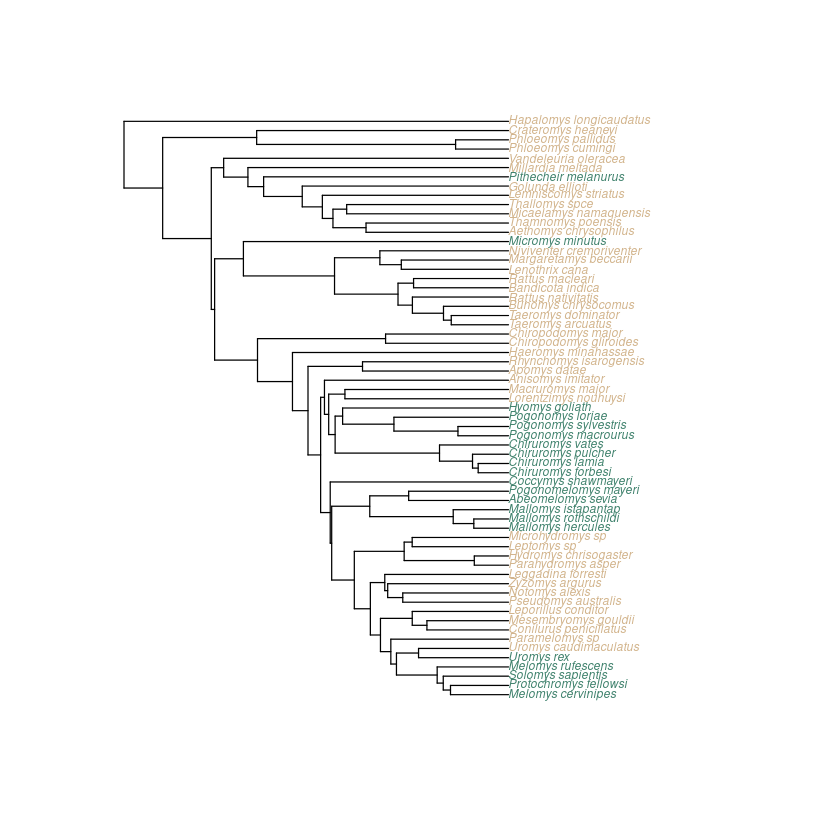

Warning message in mcp2matrix(model, linfct = linfct):
“covariate interactions found -- default contrast might be inappropriate”


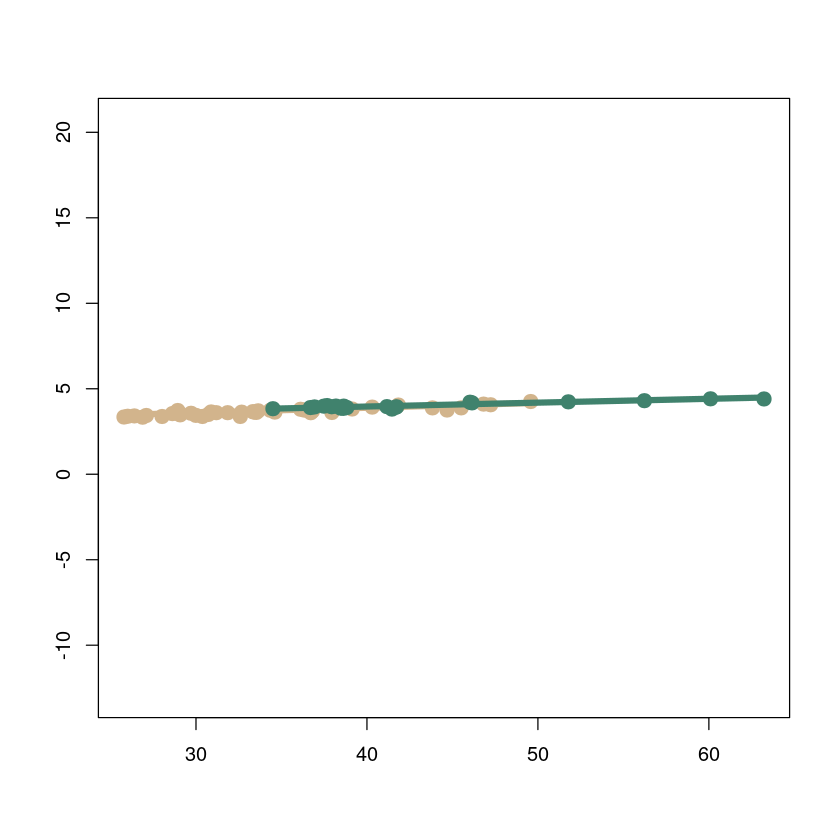


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: gls(model = log(Y) ~ log(X) * Group - 1, data = df_temp, correlation = corBM)

Linear Hypotheses:
           Estimate Std. Error z value Pr(>|z|)    
P - N == 0    7.424      0.220   33.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)

[1] 0.1081721 0.3170506
Approximate 95% confidence intervals

 Coefficients:
                    lower      est.     upper
log(X)         0.10817207 0.2126113 0.3170506
GroupN         3.34551507 3.5666237 3.7877324
GroupP         3.60948540 3.8575548 4.1056241
log(X):GroupP -0.05345421 0.1196819 0.2928179

 Residual standard error:
    lower      est.     upper 
0.1921813 0.2267267 0.2765300 
  parameter     lower  estimate     upper
1    beta() 0.1081721 0.2126113 0.3170506
2    beta() 0.1921952 0.3322932 0.4723912


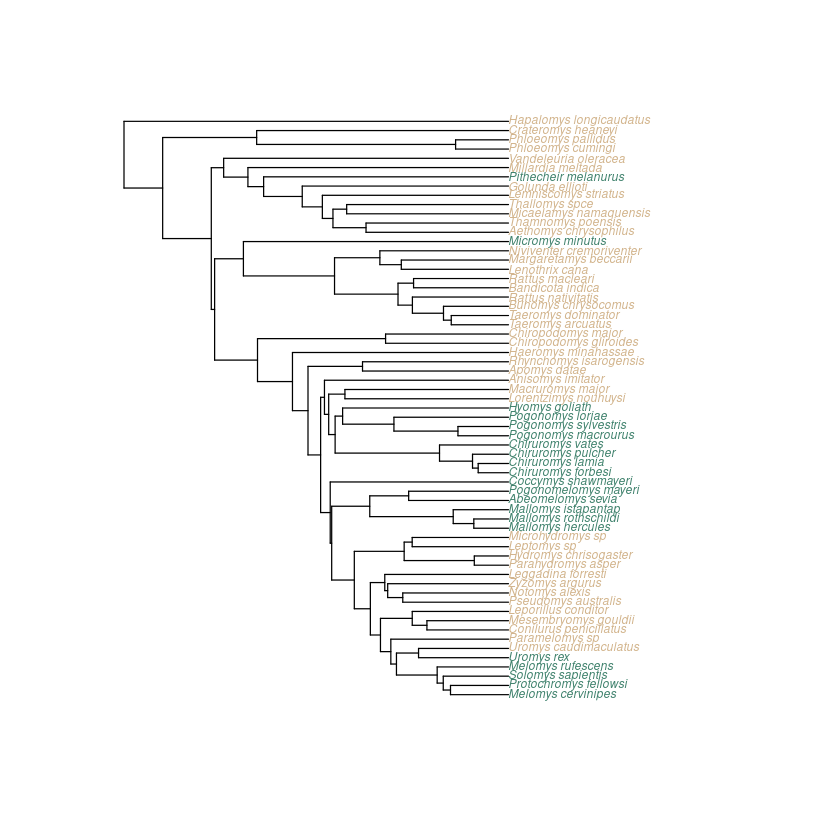

Warning message in mcp2matrix(model, linfct = linfct):
“covariate interactions found -- default contrast might be inappropriate”


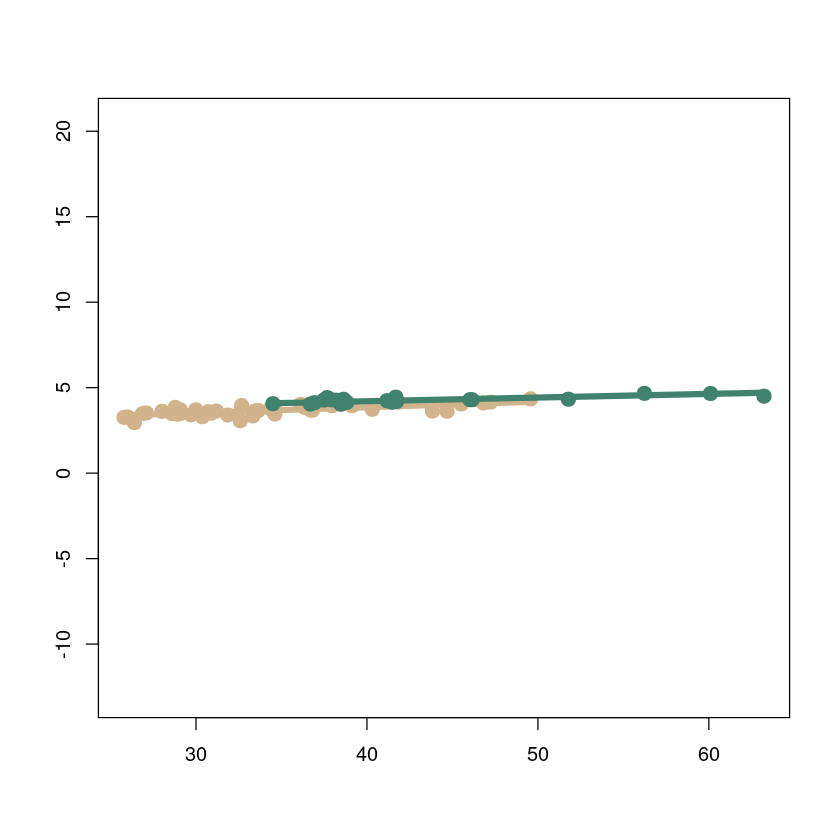


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: gls(model = log(Y) ~ log(X) * Group - 1, data = df_temp, correlation = corBM)

Linear Hypotheses:
           Estimate Std. Error z value Pr(>|z|)    
P - N == 0   7.7900     0.3879   20.08   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)

[1] -0.1106957  0.2576606
Approximate 95% confidence intervals

 Coefficients:
                   lower       est.     upper
log(X)        -0.1106957 0.07348245 0.2576606
GroupN         3.2272381 3.61716223 4.0070863
GroupP         3.7353803 4.17284950 4.6103187
log(X):GroupP -0.2139043 0.09142037 0.3967450

 Residual standard error:
    lower      est.     upper 
0.3389108 0.3998315 0.4876593 
  parameter       lower   estimate     upper
1    beta() -0.11069567 0.07348245 0.2576606
2    beta() -0.08215934 0.16490282 0.4119650


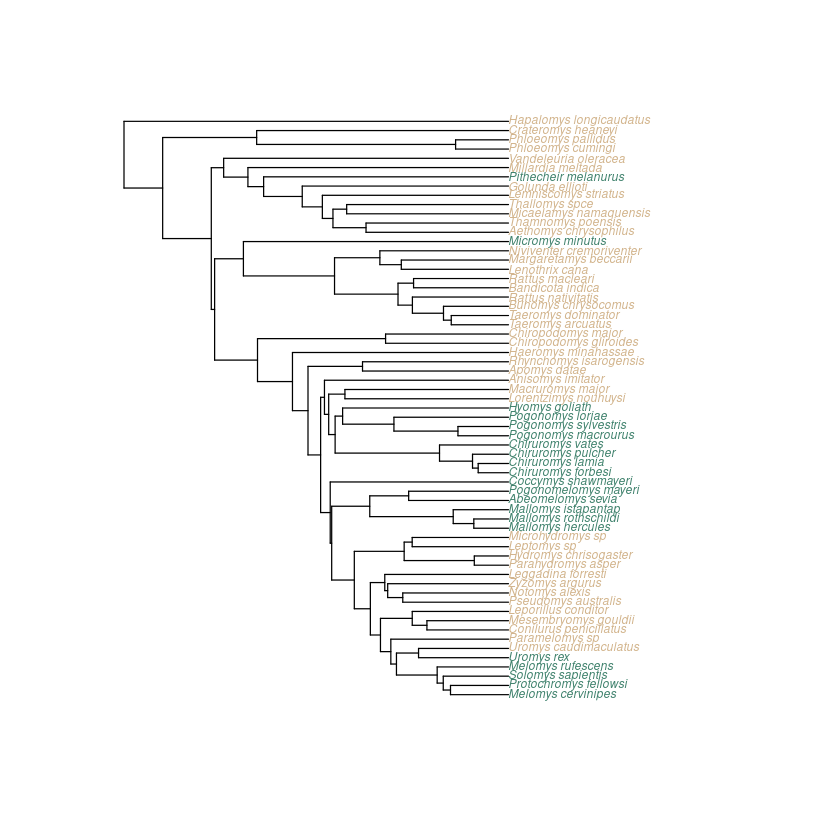

In [12]:
for (i in c(10,13,14,15,18,19)){
  df_temp<-tablePANCOVA[,c(2,20,i,9)]
  colnames(df_temp)<-c("Genus_species", "Group", "Y", "X")
  df_temp$Group<-as.factor(df_temp$Group)
  spp<-tablePANCOVA[,2]
  pancova(tablePANCOVA[,c(i,10)], phy_omit, tablePANCOVA, i, spp, df_temp)
}  